In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [186]:
class PhotonGas:
    def __init__(self, epsilon, beta, n_init, mc_steps):
        self.rng = np.random.default_rng()
        self.epsilon = epsilon
        self.beta = beta
        self.be = epsilon*beta
        #self.configs = {n_init:1}
        self.n_old = n_init
        self.n_new = None
        self.n_steps = mc_steps
        self.istep = 0
        
        self.U = self.get_U(self.n_old)
        self.U_traj = np.zeros(mc_steps)
        self.U_traj[self.istep] = self.U
        self.n_traj = np.zeros(mc_steps)
        self.n_traj[self.istep] = self.n_old
    
    def get_U(self, n):
        return self.epsilon*n
    
    def decide_accept(self):
        u_new = self.get_U(self.n_new)
        u_old = self.get_U(self.n_old)
        if u_new <= u_old:
            # accept
            self.do_accept(u_new)
        else:
            # conditional acceptance
            rand = self.rng.uniform()
            if (np.exp(-self.beta*(u_new-u_old)) > rand):
                self.do_accept(u_new)
            else:
                #self.configs[self.n_old] += 1
                self.U = u_old
            
    def do_accept(self, u_new):
        self.n_old = self.n_new
        self.U = u_new
        #if self.n_new in self.configs.keys():
        #    self.configs[self.n_new] += 1
        #else:
        #    self.configs[self.n_new] = 1
        
    def do_mc_steps(self):
        while self.istep < self.n_steps-1:
            self.istep += 1
            self.generate_trial_move()
            self.decide_accept()
            self.U_traj[self.istep] = self.U
            self.n_traj[self.istep] = self.n_old
        
    def generate_trial_move(self):
        rand = self.rng.uniform()
        
        if (rand >= 0.5):
            self.n_new = self.n_old + 1
        else:
            self.n_new = self.n_old - 1
            
        if self.n_new < 0:
            self.n_new = 0

92.872327
99.50083333194551


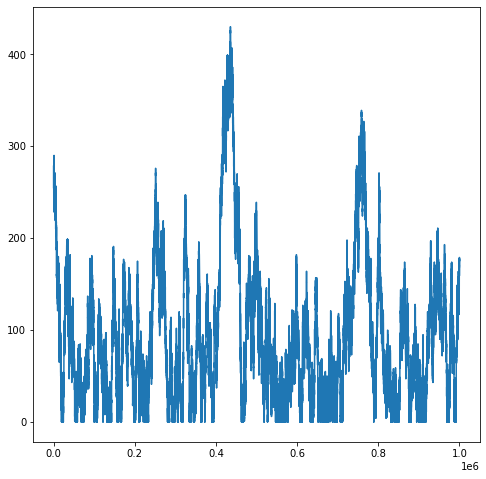

In [210]:
be = 0.01
nsteps = 5000000
neqm = int(nsteps*0.8)
a = PhotonGas(1,be,50,nsteps)
a.do_mc_steps()

f,ax = plt.subplots(figsize=(8,8))
ax.plot(a.n_traj[neqm:])
print(np.average(a.n_traj[neqm:]))
print(1.0/(np.exp(be)-1))